### To classify a test image

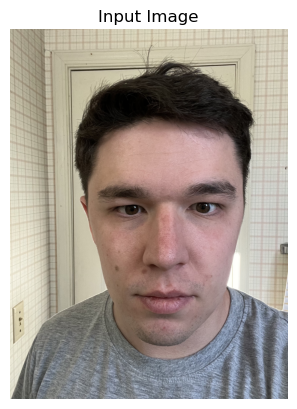


Predicted Attributes:
5_o_Clock_Shadow: No
Arched_Eyebrows: No
Attractive: No
Bags_Under_Eyes: No
Bald: No
Bangs: No
Big_Lips: No
Big_Nose: No
Black_Hair: Yes
Blond_Hair: No
Blurry: No
Brown_Hair: No
Bushy_Eyebrows: Yes
Chubby: No
Double_Chin: No
Eyeglasses: No
Goatee: No
Gray_Hair: No
Heavy_Makeup: No
High_Cheekbones: No
Male: Yes
Mouth_Slightly_Open: No
Mustache: No
Narrow_Eyes: No
No_Beard: Yes
Oval_Face: No
Pale_Skin: No
Pointy_Nose: No
Receding_Hairline: No
Rosy_Cheeks: No
Sideburns: No
Smiling: No
Straight_Hair: Yes
Wavy_Hair: No
Wearing_Earrings: No
Wearing_Hat: No
Wearing_Lipstick: No
Wearing_Necklace: No
Wearing_Necktie: No
Young: Yes


In [73]:

import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import random

# List of attributes, in order I think
attribute_names = [
    "5_o_Clock_Shadow", "Arched_Eyebrows", "Attractive", "Bags_Under_Eyes", "Bald",
    "Bangs", "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair",
    "Blurry", "Brown_Hair", "Bushy_Eyebrows", "Chubby", "Double_Chin",
    "Eyeglasses", "Goatee", "Gray_Hair", "Heavy_Makeup", "High_Cheekbones",
    "Male", "Mouth_Slightly_Open", "Mustache", "Narrow_Eyes", "No_Beard",
    "Oval_Face", "Pale_Skin", "Pointy_Nose", "Receding_Hairline", "Rosy_Cheeks",
    "Sideburns", "Smiling", "Straight_Hair", "Wavy_Hair", "Wearing_Earrings",
    "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace", "Wearing_Necktie", "Young"
]

# define the model 
class MultiLabelResNet(nn.Module):
    def __init__(self):
        super(MultiLabelResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 40),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiLabelResNet().to(device)
model.load_state_dict(torch.load('CelebA_resnet18.pth', map_location=device))
model.eval()

# Define the transform (same as training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# load and preprocess image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_transformed = transform(image).unsqueeze(0)  # Add batch dimension
    return image, image_transformed.to(device)  # Return original PIL image and tensor

# predict labels
def predict(image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        predicted_labels = (output > 0.5).int().cpu().numpy().flatten()
    return predicted_labels

# usage for predicting with one image
if __name__ == "__main__":
    image_path = "new_test.jpg"  # image path
    pil_img, image_tensor = load_and_preprocess_image(image_path)
    labels = predict(image_tensor)

    # Show the image
    plt.imshow(pil_img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print the predicted labels
    print("\nPredicted Attributes:")
    for attr, label in zip(attribute_names, labels):
        print(f"{attr}: {'Yes' if label else 'No'}")



### To find closest 5 matches

/home/wgp3aq/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wgp3aq/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


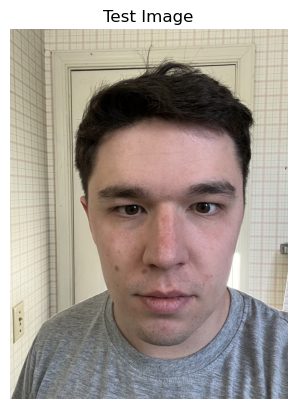


Predicted Essential Attributes:
Male: Yes
Oval_Face: No
Black_Hair: Yes
Blond_Hair: No
Brown_Hair: No
Gray_Hair: No
Heavy_Makeup: No
Young: Yes
Bald: No
Straight_Hair: Yes
Wavy_Hair: No
Pointy_Nose: No
Chubby: No
Bangs: No
Goatee: No
Narrow_Eyes: No

Finding top 5 closest matches...


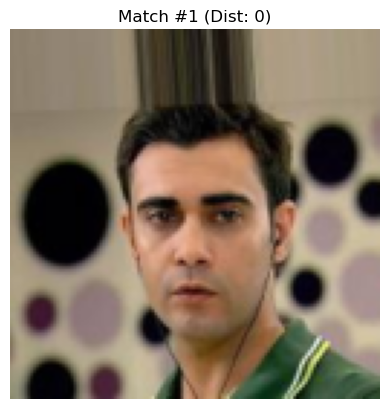

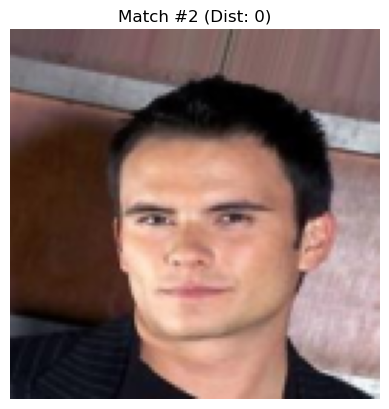

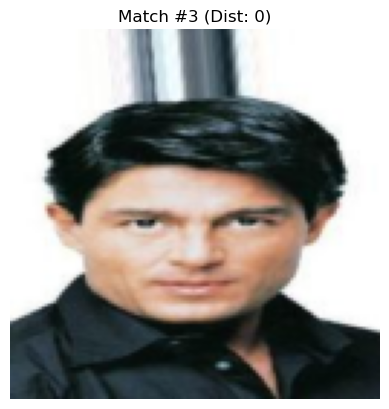

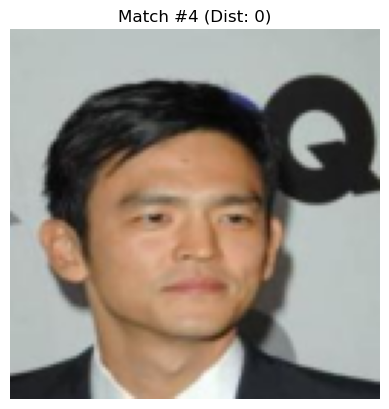

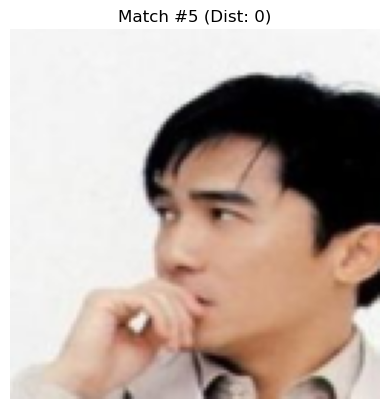

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#### A lot of this code repeats the previous chunk #####



attribute_names = CelebA(root='data', split='train', target_type='attr', download=False).attr_names

class MultiLabelResNet(nn.Module):
    def __init__(self):
        super(MultiLabelResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 40),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiLabelResNet().to(device)
model.load_state_dict(torch.load('CelebA_resnet18.pth', map_location=device))
model.eval()


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

def load_and_preprocess_image(image_path):
    pil_image = Image.open(image_path).convert('RGB')
    tensor_image = transform(pil_image).unsqueeze(0).to(device)
    return pil_image, tensor_image

def predict(image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        predicted_labels = (output > 0.5).int().cpu().numpy().flatten()
    return predicted_labels

# Find top matches (with early exit)
def find_top_matches(predicted_labels, dataset, priority_indices, top_k=5):
    candidate_indices = []

    # filter to match essential attributes first
    for i in range(len(dataset)):
        _, label = dataset[i]
        if all(label[idx] == predicted_labels[idx] for idx in priority_indices):
            candidate_indices.append(i)

    if len(candidate_indices) == 0:
        print("No matches found that satisfy all essential attributes.")
        return []

    if len(candidate_indices) <= top_k:
        print(f"Found only {len(candidate_indices)} images that match all essential attributes. Exiting early.")
        return [(idx, 0) for idx in candidate_indices]

    # rank by similarity on non-priority attributes second
    other_indices = [i for i in range(40) if i not in priority_indices]
    distances = []
    for i in candidate_indices:
        _, label = dataset[i]
        label = label.numpy()
        dist = np.sum(np.abs(predicted_labels[other_indices] - label[other_indices]))  # Hamming distance
        distances.append((i, dist))

    top_matches = sorted(distances, key=lambda x: x[1])[:top_k]
    return top_matches

# show matches
def show_matches(matches, dataset, title_prefix="Match"):
    for rank, (idx, dist) in enumerate(matches):
        image, _ = dataset[idx]
        plt.imshow(transforms.ToPILImage()(image))
        plt.axis('off')
        plt.title(f"{title_prefix} #{rank+1} (Dist: {dist})")
        plt.show()


# Set priority attributes (change to whatever makes sense to you)
priority_attrs = ['Male', 'Oval_Face', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 
                  'Gray_Hair', 'Heavy_Makeup', 'Young', 'Bald', "Straight_Hair", 
                  "Wavy_Hair", "Pointy_Nose", "Chubby", "Bangs", "Goatee", "Narrow_Eyes"]

priority_indices = [attribute_names.index(attr) for attr in priority_attrs]
train_dataset = CelebA(root='data', split='train', target_type='attr', download=False, transform=transform)

# Test with an image
if __name__ == "__main__":
    image_path = "new_test.jpg"  # image path
    pil_img, image_tensor = load_and_preprocess_image(image_path)
    predicted_labels = predict(image_tensor)

    # display image
    plt.imshow(pil_img)
    plt.axis('off')
    plt.title("Test Image")
    plt.show()

    # display predicted attributes for priority attributes
    print("\nPredicted Essential Attributes:")
    for attr in priority_attrs:
        idx = attribute_names.index(attr)
        print(f"{attr}: {'Yes' if predicted_labels[idx] else 'No'}")

    # matches
    print("\nFinding top 5 closest matches...")
    top_matches = find_top_matches(predicted_labels, train_dataset, priority_indices)
    show_matches(top_matches, train_dataset)
